### 🩺 Definição do Problema

Este projeto investiga a detecção de manipulações artificiais em imagens de tomografia computadorizada (CT), incluindo técnicas de injection (adição de nódulos falsos) e removal (remoção de lesões reais). Com o aumento de fraudes e modificações digitais em exames, torna-se essencial desenvolver métodos automáticos que identifiquem alterações e apoiem a triagem e auditoria clínica.

### 🎯 Objetivos

Treinar um modelo baseado em Vision Transformer (ViT) para classificar diferentes tipos de manipulação em exames de CT.

Avaliar o desempenho por métricas clássicas de classificação.

Aplicar métodos de explicabilidade (ViT-CAM) para entender onde o modelo foca.

Gerar visualizações úteis para validação clínica e auditoria.

### 👥 Personas

Pessoas que precisam verificar a autenticidade dos exames.

Desenvolvedores de sistemas de auditoria e detecção de fraudes médicas.

###❓ Perguntas de Pesquisa

O modelo ViT consegue identificar imagens manipuladas de forma confiável?

As regiões destacadas pelo ViT-CAM fazem sentido para validação clínica?

## Setup


In [ ]:
# 0) Runtime: GPU (Runtime > Change runtime type > GPU)
# 1) Instalação de dependências
!pip install -q kaggle
!pip install -q git+https://github.com/ultralytics/yolov5.git  # instala yolov5 (PyTorch)
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q scikit-learn opencv-python matplotlib pandas seaborn tqdm
!pip install -q grad-cam
!pip install kagglehub[pandas-datasets]
!pip install timm einops opencv-python
!pip install split-folders

  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# =========================================
# 📦 IMPORTS — Organização por categorias
# =========================================

# ---------------------------
# 🔥 PyTorch (Core)
# ---------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# ---------------------------
# 🖼️ TorchVision (Datasets & Transforms)
# ---------------------------
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision import transforms

# ---------------------------
# 📊 Métricas e Avaliação
# ---------------------------
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# ---------------------------
# 📈 Visualização
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns  # opcional, mas útil

# ---------------------------
# 🧮 Utilidades Numéricas
# ---------------------------
import numpy as np
import pandas as pd

# ---------------------------
# 📁 Manipulação de Arquivos
# ---------------------------
import os
import glob
import json
import shutil

# ---------------------------
# 🖼️ OpenCV
# ---------------------------
import cv2

# ---------------------------
# 🧠 Modelos pré-treinados (timm)
# ---------------------------
import timm

# ---------------------------
# 🔄 Scheduler para LR
# ---------------------------
from torch.optim.lr_scheduler import CosineAnnealingLR

# ---------------------------
# 📂 Split folders
# ---------------------------
import splitfolders

# ---------------------------
# 💾 Google Colab
# ---------------------------
from google.colab import drive, userdata

# =========================================
print("✔️ Imports carregados com sucesso!")

## Baixando o dataset do Kaggle
URL: https://www.kaggle.com/datasets/freddiegraboski/btd-mri-and-ct-deepfake-test-sets?select=MRI


In [ ]:
token = userdata.get("KAGGLE_API_TOKEN")

KAGGLE_USERNAME = "lauratracierra"

try:
    kaggle_dict = json.loads(token)
    print("✅ Token detectado como JSON.")
except:
    print("⚠️ Token não é JSON, tratando como KEY simples.")
    kaggle_dict = {
        "username": KAGGLE_USERNAME,
        "key": token.strip()
    }

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("✅ kaggle.json criado com sucesso!")


⚠️ Token não é JSON, tratando como KEY simples.
✅ kaggle.json criado com sucesso!


In [ ]:
!kaggle datasets download -d freddiegraboski/btd-mri-and-ct-deepfake-test-sets -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/freddiegraboski/btd-mri-and-ct-deepfake-test-sets
License(s): GNU Affero General Public License 3.0
 97% 1.22G/1.25G [00:13<00:00, 277MB/s]
100% 1.25G/1.25G [00:13<00:00, 102MB/s]


## Dataset

O dataset contém imagens de Tomagrafias Computadorizadas (CT SCAN) geradas a partir de volumes .npy e convertidas para .png. Ele inclui diferentes cenários de manipulação produzidos por técnicas como CTGAN, Stable Diffusion e imagens reais.
As principais variáveis incluem:

Intensidades normalizadas da imagem (escala HU convertida para 0–255);

Classe de manipulação (ex.: FB_CTGAN, FM_SD, FM_CTGAN, FB_SD);
Classe real (ex: TM e TB)

Classes:
- Injection:
1. FM_CTGAN: Fake-Malign (cancer added using CTGAN)
2. FM_SD: Fake-Malign (cancer added using Stable Diffusion)
3. TM: True-Malign (authentic images with malignant tumors)
- Removal:
1. FB_CTGAN: Fake-Benign (cancer removed using CTGAN)
2. FB_SD: Fake-Benign (cancer removed using Stable Diffusion)
3. TB: True-Benign (authentic images without tumors)

Estrutura hierárquica mantendo injection e removal originais.

O dataset é organizado em pastas por classe, e depois dividido em treino, validação e teste (70/15/15).

In [ ]:
# ================================================================
# 📌 Etapa 1 — Inspeção Inicial da Estrutura do Dataset Bruto
# ================================================================

# Nesta etapa verificamos quais pastas, arquivos e hierarquias
# foram extraídos no ambiente do Google Colab.
# Isso é essencial para entender como o dataset foi organizado
# originalmente (CT injection / CT removal).

base = "/content"

print("📂 Estrutura parcial do diretório /content:\n")
for root, dirs, files in os.walk(base):
    # evitar listar coisas muito superficiais
    if root.count("/") <= 2:
        continue

    print(f"📁 {root}")
    break  # apenas uma amostra

print("\n📄 Arquivos ou pastas encontrados na raiz:")
print(sorted(os.listdir("/content"))[:50])


Arquivos e pastas extraídos (exemplos):
['.config', 'CT', 'MRI', 'sample_data']


In [ ]:
# ================================================================
# 📌 Etapa 2 — Conversão de .npy para PNG com normalização HU
# ================================================================
# Aqui transformamos os volumes .npy em imagens 2D .png,
# mantendo a estrutura injection/removal original.
#
# Normalização HU aplicada:
#  - recorte entre -700 e 2000 HU
#  - normalização para [0, 255]
#  - conversão para uint8 para salvar como PNG
# ================================================================

ct_base = "/content/CT"              # pasta com arquivos .npy
output_ct = "/content/CT_images"     # pasta destino das imagens PNG

os.makedirs(output_ct, exist_ok=True)

for root, dirs, files in os.walk(ct_base):
    for file in files:
        if file.endswith(".npy"):
            path = os.path.join(root, file)

            # carrega a imagem CT
            arr = np.load(path)

            # ---- Normalização típica de CT (HU windowing) ----
            arr = np.clip(arr, -700, 2000)
            arr = (arr + 700) / 2700     # normalizar  [-700,2000] → [0,1]
            arr = (arr * 255).astype("uint8")  # para PNG

            # novo nome .png
            new_name = file.replace(".npy", ".png")

            # preserva subpastas injection/removal
            relative = root.replace(ct_base, "").strip("/")
            save_dir = os.path.join(output_ct, relative)
            os.makedirs(save_dir, exist_ok=True)

            cv2.imwrite(os.path.join(save_dir, new_name), arr)

print("✅ Conversão CT → PNG concluída.")


✅ CT convertido para PNG mantendo injection/removal.


In [ ]:
# ================================================================
# 📌 Etapa 3 — Organização final no formato padrão (ImageFolder)
# ================================================================
# Aqui reestruturamos o dataset para o formato necessário
# para treinamento com PyTorch:
#
# /CT_final
#     ├── FM_CTGAN
#     ├── FM_SD
#     ├── TM
#     ├── FB_CTGAN
#     ├── FB_SD
#     └── TB
# ================================================================

classes = ["FM_CTGAN", "FM_SD", "TM", "FB_CTGAN", "FB_SD", "TB"]

ct_images = "/content/CT_images"
final_ct = "/content/CT_final"

# cria pastas finais
for cls in classes:
    os.makedirs(os.path.join(final_ct, cls), exist_ok=True)

# distribui imagens para as pastas certas
for root, dirs, files in os.walk(ct_images):
    for file in files:
        if file.endswith(".png"):
            full_path = os.path.join(root, file)

            for cls in classes:
                if f"/{cls}/" in root:
                    dest = os.path.join(final_ct, cls)
                    shutil.copy(full_path, os.path.join(dest, file))

print("✅ Dataset CT_final organizado corretamente.")


✅ Dataset CT final organizado.


In [ ]:
# ================================================================
# 📌 Etapa 4 — Montando o Google Drive
# ================================================================

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ================================================================
# 📌 Etapa 5 — Divisão em Train / Validation / Test
# ================================================================
# Utilizamos o splitfolders para criar:
#  - 70% treino
#  - 15% validação
#  - 15% teste
# garantindo reprodutibilidade via seed
# ================================================================

splitfolders.ratio(
    input="/content/CT_final",
    output="/content/CT_split",
    seed=42,
    ratio=(0.7, 0.15, 0.15)
)

print("✅ Divisão Train/Val/Test finalizada.")


Copying files: 1109 files [00:00, 4670.33 files/s]

✅ Split concluído.


### 📊 Estatísticas por classe

No próximo bloco vamos contar quantas imagens existem em cada categoria
para entender se há desbalanceamento.


In [ ]:
# ================================================================
# 📊 Contagem de imagens por classe
# ================================================================

counts = {}
for cls in classes:
    counts[cls] = len(os.listdir(f"{final_ct}/{cls}"))

pd.DataFrame.from_dict(counts, orient="index", columns=["n_imagens"])


,n_imagens
FM_CTGAN,353
FM_SD,353
TM,109
FB_CTGAN,98
FB_SD,98
TB,98


### Modelo

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transformações aplicadas apenas no conjunto de treino.
# Incluem data augmentation para aumentar a generalização do modelo
# e reduzir overfitting, algo essencial ao treinar ViT com dataset pequeno.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),      # Aumenta robustez a reflexões horizontais
    transforms.RandomRotation(10),          # Aumenta invariância a pequenas rotações
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variações de iluminação
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   # Simula zoom e mudança de escala
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],       # Padroniza para ViTs do TIMM
                         std =[0.229, 0.224, 0.225]),
])

# Carregamento das pastas já separadas pelo método Injection / Removal
# Cada pasta contém as classes necessárias para identificação dos artefatos.
train_dataset = ImageFolder("/content/CT_split/train", transform=train_transform)
val_dataset   = ImageFolder("/content/CT_split/val", transform=train_transform)
test_dataset  = ImageFolder("/content/CT_split/test", transform=train_transform)

# Definição dos loaders, com shuffle apenas no treino para evitar viés de ordem
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("✅ Classes detectadas:", train_dataset.classes)


✅ Classes detectadas: ['FB_CTGAN', 'FB_SD', 'FM_CTGAN', 'FM_SD', 'TB', 'TM']


In [ ]:
# Cálculo automático de pesos das classes para lidar com desbalanceamento.
# Essencial para deepfake, pois algumas manipulações (ex: Removal) aparecem menos.
# O CrossEntropy usa esses pesos para penalizar mais erros de classes raras.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.targets),
    y=train_dataset.targets
)

# Conversão para tensor e envio ao dispositivo (GPU ou CPU).
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [ ]:
# Criação do ViT Small (tamanho intermediário) pré-treinado no ImageNet.
# O uso de pretrained é essencial para ViT funcionar bem em dataset pequeno.
model = timm.create_model(
    "vit_small_patch16_224",
    pretrained=True,
    num_classes=6
).to(device)

# Etapa 1: congelamento completo.
# Isso evita que os pesos pré-treinados do ViT sejam destruídos no início.
for param in model.parameters():
    param.requires_grad = False

# Etapa 2: descongelar apenas o último bloco Transformer.
# Isso permite fine-tuning leve, ajustando apenas a parte mais semântica do ViT.
for param in model.blocks[-1].parameters():
    param.requires_grad = True

# Etapa 3: fully fine-tune da head de classificação.
# A head é nova (num_classes=6), então precisa treinar do zero.
for param in model.head.parameters():
    param.requires_grad = True

# Loss com pesos das classes para lidar com desbalanceamento.
criterion = nn.CrossEntropyLoss(weight=class_weights)

# AdamW é o otimizador recomendado para Vision Transformers (dos papers originais).
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,            # LR inicial pequena devido ao fine-tuning
    weight_decay=0.05    # Regularização sugerida para ViT
)

# Agendador Cosine Annealing — reduz a taxa de aprendizado
# de forma suave, geralmente melhora estabilidade do ViT.
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=15,   # ciclo completo de decaimento em 15 épocas
    eta_min=1e-6
)

# Mixup/CutMix — técnicas essenciais para ViT.
# Elas aumentam muito a generalização porque ViT depende fortemente de regularização.
from timm.data.mixup import Mixup
mixup_fn = Mixup(
    mixup_alpha=0.8,      # intensidade do mixup
    cutmix_alpha=1.0,     # probabilidade e força do cutmix
    label_smoothing=0.1,  # reduz overconfidence (importante para ViT)
    num_classes=6
)

# AMP (Mixed Precision) reduz memória e acelera, sem perder acurácia.
scaler = torch.cuda.amp.GradScaler()


/tmp/ipython-input-1747631418.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    # Loop padrão de treinamento — recebe batches de imagens + rótulos
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed Precision — reduz custo e mantém estabilidade
        with torch.cuda.amp.autocast():
            outputs = model(images)

            # Mixup produz labels misturados (probabilísticos)
            # CrossEntropyLoss consegue lidar com isso via Soft Labels
            loss = criterion(outputs, labels)

        # Backprop usando GradScaler para FP16
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Acumula perda — não se calcula acurácia aqui porque Mixup distorce labels
        total_loss += loss.item()

    # Retorna perda média
    return total_loss / len(loader)


In [ ]:
def eval_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    # Avaliação sempre sem Mixup e sem gradiente
    with torch.no_grad():
        with torch.cuda.amp.autocast():   # FP16 também na inferência
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = outputs.max(1)

                # Cálculo tradicional de acurácia (aqui sim!)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                # Armazenamento para relatório posterior
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    return acc, all_labels, all_preds


In [ ]:
for epoch in range(15):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Aplicação de Mixup/CutMix — aumenta robustez e evita overfitting,
        # especialmente importante para Vision Transformers.
        images, labels = mixup_fn(images, labels)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backprop com FP16 e GradScaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Não calculamos acurácia aqui porque mixup altera rótulos
        running_loss += loss.item() * images.size(0)

    # Perda média da época
    train_loss = running_loss / len(train_loader.dataset)

    # Avaliação no conjunto de validação (sem mixup)
    val_acc, _, _ = eval_model(model, val_loader)

    # Atualiza taxa de aprendizado com Cosine Annealing
    scheduler.step()

    print(f"Epoch {epoch+1}/15 | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")


/tmp/ipython-input-3090569536.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/15 | Loss: 1.9712 | Val Acc: 0.3210
Epoch 2/15 | Loss: 1.7841 | Val Acc: 0.4136
Epoch 3/15 | Loss: 1.7555 | Val Acc: 0.4691
Epoch 4/15 | Loss: 1.6903 | Val Acc: 0.5802
Epoch 5/15 | Loss: 1.6676 | Val Acc: 0.5802
Epoch 6/15 | Loss: 1.7073 | Val Acc: 0.5617
Epoch 7/15 | Loss: 1.6669 | Val Acc: 0.5247
Epoch 8/15 | Loss: 1.6244 | Val Acc: 0.5926
Epoch 9/15 | Loss: 1.6197 | Val Acc: 0.6235
Epoch 10/15 | Loss: 1.6659 | Val Acc: 0.6481
Epoch 11/15 | Loss: 1.6197 | Val Acc: 0.5926
Epoch 12/15 | Loss: 1.5757 | Val Acc: 0.6481
Epoch 13/15 | Loss: 1.5993 | Val Acc: 0.6543
Epoch 14/15 | Loss: 1.6044 | Val Acc: 0.6481
Epoch 15/15 | Loss: 1.5829 | Val Acc: 0.6543


## Métricas

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🔎 Validation Accuracy: 0.6543

📋 Classification Report:

              precision    recall  f1-score   support

    FB_CTGAN       0.15      0.14      0.15        14
       FB_SD       0.56      0.36      0.43        14
    FM_CTGAN       0.82      0.79      0.80        52
       FM_SD       0.92      0.94      0.93        52
          TB       0.22      0.29      0.25        14
          TM       0.26      0.31      0.29        16

    accuracy                           0.65       162
   macro avg       0.49      0.47      0.48       162
weighted avg       0.67      0.65      0.66       162



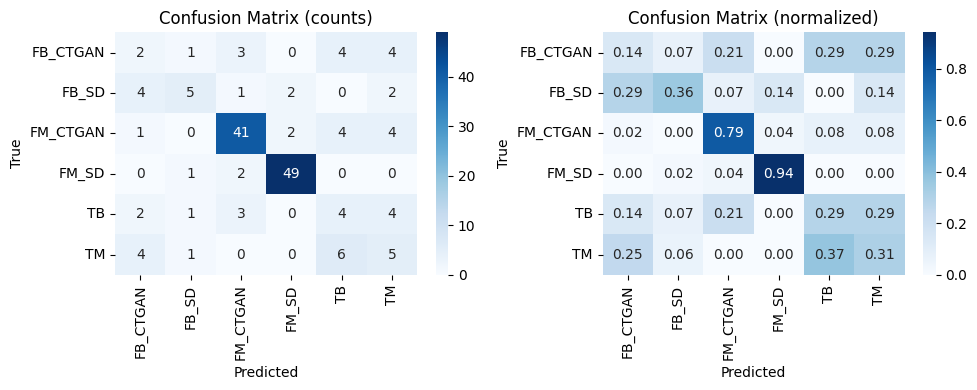

In [ ]:
# ================================================================
# 📊 Avaliação: Validation Accuracy, Classification Report, Confusion Matrix
# ================================================================
# usa a função eval_model já presente no notebook
val_acc, y_true, y_pred = eval_model(model, val_loader)

print("\n🔎 Validation Accuracy:", f"{val_acc:.4f}\n")

# Classification report com nomes legíveis das classes
from sklearn.metrics import classification_report, confusion_matrix
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, zero_division=0))

# Matriz de confusão e plot (contagem e normalizada)
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

import seaborn as sns
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix (counts)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix (normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


## ViT CAM

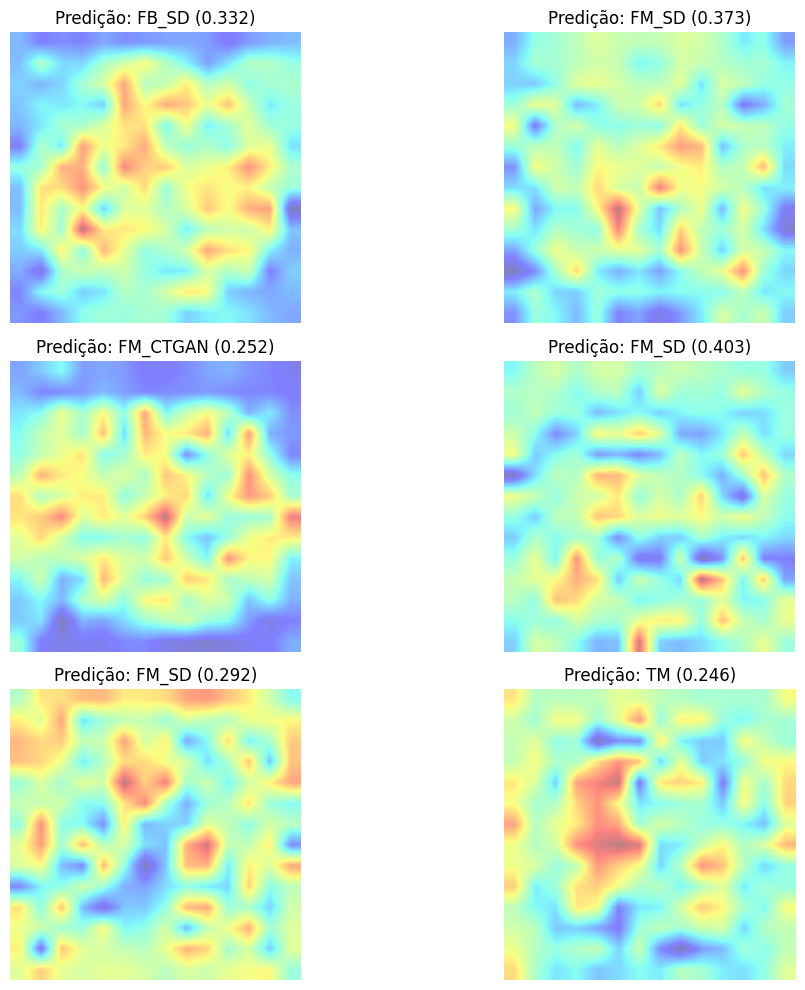

In [ ]:
# ---- CONFIG ----
CLASSES = [
    "FB_CTGAN",
    "FB_SD",
    "FM_CTGAN",
    "FM_SD",
    "TB",
    "TM"
]

TEST_DIR = "/content/CT_split/test"
IMG_SIZE = 224

# Lista onde salvaremos temporariamente os mapas de atenção obtidos via hook
attention_maps = []


# Essa função é chamada automaticamente quando o módulo escolhido executa forward()
# É assim que capturamos as matrizes de atenção do ViT sem modificar o modelo.
def attn_hook(module, input, output):
    attention_maps.append(output)



def vit_cam(model, input_tensor, class_idx):
    model.eval()  # modo de inferência

    # Garante que o input seja 4D
    if input_tensor.dim() == 3:
        input_tensor = input_tensor.unsqueeze(0)

    input_tensor = input_tensor.to(device)

    attentions = []  # onde será guardada a atenção capturada

    # Hook para capturar a matriz de atenção da *última camada* do encoder ViT.
    def hook_fn(module, input, output):
        # Em algumas implementações o self-attention retorna tupla (out, attn)
        if isinstance(output, tuple):
            attentions.append(output[1])
        else:
            attentions.append(output)

    # Registramos o hook na última camada de atenção
    hook_handle = model.encoder.layers[-1].self_attention.register_forward_hook(hook_fn)

    # Rodamos uma inferência completa → o hook captura a atenção automaticamente
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)

    # Removemos o hook para evitar capturas indesejadas nas próximas inferências
    hook_handle.remove()

    # Verificação de segurança
    if len(attentions) == 0:
        raise RuntimeError("Nenhuma atenção capturada. Confirme o hook.")

    attn = attentions[0]  # Pegamos a matriz de atenção capturada

    # Se veio em formato inadequado, abortamos para evitar resultados enganosos
    if attn.dim() == 3:
        raise ValueError(f"Atenção errada: {attn.shape}")

    # Atenção tem formato [batch, heads, tokens, tokens]
    # Fazemos média dos heads → reduz ruído e dá atenção agregada
    attn = attn.mean(dim=1)

    # Usamos apenas a atenção do CLS para os patches → padrão em ViT-CAM
    # Índice 1: ignora o token CLS
    cam = attn[0, 0, 1:]

    if cam.numel() == 0:
        raise RuntimeError("Mapa de atenção vazio.")

    # Normalização min-max
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # Converte atenção 1D para grid 14×14
    cam = cam.reshape(14, 14).detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    # Retorna heatmap e confiança
    return cam, probs[0, class_idx].item()



# ---- VISUALIZA 1 IMAGEM POR CLASSE ----
plt.figure(figsize=(12, 10))
idx = 1

for cls in CLASSES:

    class_dir = os.path.join(TEST_DIR, cls)

    # Seleciona a primeira imagem da classe para explicabilidade
    imgs = [f for f in os.listdir(class_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
    img_name = imgs[0]
    img_path = os.path.join(class_dir, img_name)

    # Carrega imagem original
    image = Image.open(img_path).convert("RGB")
    input_tensor = train_transform(image)

    # Predição do modelo
    with torch.no_grad():
        out = model(input_tensor.unsqueeze(0).to(device))
        pred_idx = torch.argmax(out, dim=1).item()
        pred_label = CLASSES[pred_idx]

    # Gera mapa de calor baseado nos pesos da camada final
    cam, confidence = vit_cam_timm(model, input_tensor, pred_idx)

    # Prepara imagem para visualização
    img_np = np.array(image.resize((IMG_SIZE, IMG_SIZE)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Exibe o CAM puro para cada classe
    plt.subplot(3, 2, idx)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Predição: {pred_label} ({confidence:.3f})")
    plt.axis("off")

    idx += 1

plt.tight_layout()
plt.show()
